# Asignment: Factoring

In [2]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import sys
import math
import pandas as pd
import matplotlib.pyplot as plt
from fractions import Fraction
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import time

np.set_printoptions(threshold=sys.maxsize)

In [3]:
def get_coeffs(x, N, n_q, n_count):
    vec = np.zeros(2**n_q)
    base = 1
    for i in range(2**n_count):
        s1 = np.binary_repr(i,n_count)
        mod2 = np.mod(base,N)
        base = mod2*x
        s2 = np.binary_repr(mod2,n_q-n_count)
        #print(i,mod2,s1,s2)
        vec[int(s2+s1,2)] = 1
    return vec

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def IsPerfectPower(n):
    for i in range(2, int(n ** 0.5) + 1):
        log_value = math.log(n, i) #log of n base i
        if log_value == int(log_value):
            return True
    return False


def calculate_guess():
    rows, measured_phases = [], []
    rowsclean = []
    for output in counts:
        decimal = int(output, 2)  # Convert (base 2) string to decimal
        phase = decimal/(2**n_count)  # Find corresponding eigenvalue
        measured_phases.append(phase)
        # Add these values to the rows in our table:
        frac = Fraction(phase).limit_denominator(N)
        #rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{decimal}/{2**n_count} = {phase:.2f}",f"{frac.numerator}/{frac.denominator}",     frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(int(x**(frac.denominator//2)-1), np.uint32(N)), np.gcd(int(x**(frac.denominator//2)+1), np.uint32(N))])
        rowsclean.append([f"{output}", f"{decimal:>3}", f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(int(x**(frac.denominator//2)-1), np.uint32(N)), np.gcd(int(x**(frac.denominator//2)+1), np.uint32(N)),counts[output]])
    # Print the rows in a table
    #headers=["Register Output", "Phase", "Fraction", "Guess for r", "guess1","guess2"]
    headers=["Register Output", "Fraction", "Guess for r", "guess1","guess2"]
    headersclean=["Output", "Decimal", "Fraction", "Guess for r", "guess1","guess2","counts"]
    df = pd.DataFrame(rows, columns=headers)
    df2 = pd.DataFrame(rowsclean, columns=headersclean)
    return(df2)

# Testing efficiency for N=35 with loop over number of qubits in QFT+ (t) and all possible values of x (form 2 to N)

In [4]:
start_time = time.time()
timelast = start_time
p = 7
q = 5
N = p*q # need of 6 qubits to store the number (smaller than 2^6=64 2^7=128 2^8=256)
bigloopeff = []
effi = []
headers2 = ["Ncount","MeanSuccess","MeanPerfectSuccess","time"]
headers=["Ncount","Xvalue","success","perfectsuccess"]
shots = 10**5 # number of shots simulated for the quantum circuit
n_count_max = 13 #(number of possible outputs 2^13 ~ 9000, need simulating circuit at least 10^5)


for n_count in range(2,n_count_max+1):
    
    n_m = int(math.log(N,2))+1
    
    n_q = n_count + n_m # total number of Qubits (QFT_register + a**i_register) (8 for N)

    for x in range(2,N):
        if IsPerfectPower(N):
            percentsuccess=100
            percentperfect=100
        elif np.gcd(x,N)>1:
            percentsuccess=100
            percentperfect=100
        else:
            vec = get_coeffs(x, N, n_q, n_count)
            vec = vec/np.sqrt(2**n_count)
            Q = QuantumCircuit(n_q,n_count) # n_q quantum bits and n_count classical bits (to measure QFT+)
            Q.initialize(vec)
            Q.append(qft_dagger(n_count),range(n_count))
            Q.measure(range(n_count),range(n_count))
            aer_sim = Aer.get_backend('aer_simulator')
            t_qc = transpile(Q, aer_sim)
            qobj = assemble(t_qc)
            results = aer_sim.run(qobj,shots=shots).result()
            counts = results.get_counts()
            dfresult = calculate_guess()
            dfgood_guess = dfresult.loc[((dfresult['guess1']!=1) | (dfresult['guess2']!=1)) & (dfresult['guess2']!=N) & (dfresult['guess1']!=N)] 
            percentsuccess = sum(np.array(dfgood_guess['counts']))/shots*100
            dfperfect_guess = dfresult.loc[((dfresult['guess1']==p) & (dfresult['guess2']==q)) | ((dfresult['guess1']==q) & (dfresult['guess2']==p)) ]
            percentperfect = sum(np.array(dfperfect_guess['counts']))/shots*100
        effi.append([n_count,x,percentsuccess,percentperfect])
        df = pd.DataFrame(effi, columns=headers)


    bigloopeff.append([n_count,df["success"].mean(),df["perfectsuccess"].mean(),time.time()-timelast])
    print(n_count,"--- %s seconds ---" % (time.time() - timelast))
    timelast = time.time()

df2 = pd.DataFrame(bigloopeff, columns = headers2)    
print(bigloopeff)    
file = open("success77.txt","w")
df2.to_csv(file)
file.close()
file = open("success77-2.txt","w")
df.to_csv(file)
file.close()

KeyboardInterrupt: 

55.00814777777778
26.975285555555555


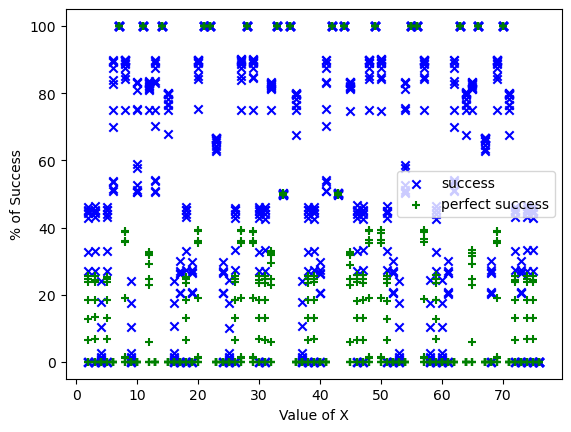

In [6]:
plt.scatter(df['Xvalue'],df['success'], color='b',label='success',marker='x')
plt.scatter(df['Xvalue'],df['perfectsuccess'], color='g',label='perfect success',marker='+')
plt.xlabel('Value of X')
plt.ylabel('% of Success')
plt.legend()
print(df['success'].mean())
print(df['perfectsuccess'].mean())